<center><h1>Thai_Khang_Final_Project</h1></center>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Transfer Learning for Image Classification

Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from pathlib import Path
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize


### (a) In this problem, we are trying to build a classifier that distinguishes images of 17 types of jute pest.

### (b) Data Exploration and Pre-processing

#### (i) One-hot Encoding

In [7]:
FILEPATH = 'resized_data' 

TRAIN_DIR = os.path.join(FILEPATH, 'train')
TEST_DIR = os.path.join(FILEPATH, 'test')
VAL_DIR = os.path.join(FILEPATH, 'val')


IMG_SIZE = (224, 224)
BATCH_SIZE = 32

temp_datagen = ImageDataGenerator()

train_temp = temp_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_temp = temp_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_temp = temp_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Training samples:", train_temp.n)
print("Validation samples:", val_temp.n)
print("Testing samples:", test_temp.n)


Found 6443 images belonging to 17 classes.
Found 413 images belonging to 17 classes.
Found 379 images belonging to 17 classes.
Training samples: 6443
Validation samples: 413
Testing samples: 379


#### (ii) Resize Images

In [4]:
sizes = []
class_dir = os.listdir(TRAIN_DIR)

for class_name in class_dir[:5]:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)[:10]
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                sizes.append(img.size)

unique_sizes = list(set(sizes))

if len(unique_sizes) > 1:
    widths = [size[0] for size in sizes]
    heights = [size[1] for size in sizes]
    print("Unique image sizes found")


RESIZED_DIR = Path('resized_data')
TARGET_SIZE = (224, 224)

def resize_images(src_dir, dst_dir, target_size):
    src_path = Path(src_dir)
    dst_path = Path(dst_dir)
    image_files = list(src_path.rglob('*.*'))
    for img_file in image_files:
        relative_path = img_file.relative_to(src_path)
        target_file_path = dst_path / relative_path
        target_file_path.parent.mkdir(parents=True, exist_ok=True)

        img = load_img(str(img_path), target_size=target_size)
        img.save(str(target_file_path))

    return len(image_files)

train_count = resize_images(TRAIN_DIR, RESIZED_DIR / 'train', TARGET_SIZE)
val_count = resize_images(VAL_DIR, RESIZED_DIR / 'val', TARGET_SIZE)
test_count = resize_images(TEST_DIR, RESIZED_DIR / 'test', TARGET_SIZE)

print(f"Resized {train_count} training images.")
print(f"Resized {val_count} validation images.")
print(f"Resized {test_count} testing images.")

TRAIN_DIR = str(RESIZED_DIR / 'train')
VAL_DIR = str(RESIZED_DIR / 'val')
TEST_DIR = str(RESIZED_DIR / 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

print("Train Samples:", train_generator.n)
print("Validation Samples:", val_generator.n)
print("Test Samples:", test_generator.n)



Unique image sizes found
Resized 6444 training images.
Resized 413 validation images.
Resized 379 testing images.
Found 6443 images belonging to 17 classes.
Found 413 images belonging to 17 classes.
Found 379 images belonging to 17 classes.
Train Samples: 6443
Validation Samples: 413
Test Samples: 379


### (c) Transfer Learning

#### (i)

In [5]:
NUM_CLASSES = 17
IMG_SHAPE = (224, 224, 3)

def create_model(base_model, num_classes=17):

    if base_model == 'ResNet50':
        base = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'ResNet101':
        base = ResNet101(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'EfficientNetB0':
        base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'VGG16':
        base = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'DenseNet201':
        base = DenseNet201(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError("Unsupported base model")

    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=predictions)
    return model, base

models = {}
base = {}
model_names = ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16', 'DenseNet201']
for name in model_names:
    model, base_model = create_model(name, NUM_CLASSES)
    models[name] = model
    base[name] = base_model

    tot_params = model.count_params()
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    frozen_params = tot_params - trainable_params

    print(f"{name} - Total params: {tot_params}, Trainable params: {trainable_params}, Frozen params: {frozen_params}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
ResNet50 - Total params: 24116625, Trainable params: 528913, Frozen params: 23587712
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
ResNet101 - Total params: 43187089, Trainable params: 528913, Frozen params: 42658176
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
EfficientNetB0 - Total params: 4381876, Trainable params: 332305, Frozen params: 4049571
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
VGG16 - Total params: 14850385, Trainable params: 135697, Frozen params: 14714688
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
DenseNet201 - Total params: 18818129, Trainable params: 496145, Frozen params: 18321984


#### (ii) Empirical Reguarization

In [6]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

print("Augmented Train Samples:", train_generator_augmented.n)

Found 6443 images belonging to 17 classes.
Augmented Train Samples: 6443


#### (iii)

In [7]:
BATCH_SIZE = 32
L2_LAMBDA = 0.001

def create_model_iii(base_model, num_classes=17):

    if base_model == 'ResNet50':
        base = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'ResNet101':
        base = ResNet101(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'EfficientNetB0':
        base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'VGG16':
        base = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif base_model == 'DenseNet201':
        base = DenseNet201(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = {}
model_names = ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16', 'DenseNet201']

for name in model_names:
    model = create_model_iii(name, NUM_CLASSES)
    models[name] = model

train_generator = train_datagen_augmented.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

print("Train Samples:", train_generator.n)
print("Validation Samples:", val_generator.n)
print("Test Samples:", test_generator.n)


Found 6443 images belonging to 17 classes.
Found 413 images belonging to 17 classes.
Found 379 images belonging to 17 classes.
Train Samples: 6443
Validation Samples: 413
Test Samples: 379


#### (iv)

In [8]:
EPOCHS = 50
PATIENCE = 10

hist = {}

for model_name in model_names:
    callback = [
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'best_model_{model_name}.keras', monitor='val_accuracy', save_best_only=True)
    ]

    start_time = time.time()
    history = models[model_name].fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callback,
        verbose=1
    )

    train_time = time.time() - start_time
    hist[model_name] = history

    print(f"{model_name} Training Time: {train_time:.2f} seconds")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 114s 482ms/step - accuracy: 0.0924 - loss: 2.8869 - val_accuracy: 0.1719 - val_loss: 2.7882
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 389ms/step - accuracy: 0.0922 - loss: 2.8068 - val_accuracy: 0.1719 - val_loss: 2.8034
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 388ms/step - accuracy: 0.1006 - loss: 2.8042 - val_accuracy: 0.1719 - val_loss: 2.8112
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 389ms/step - accuracy: 0.0940 - loss: 2.8078 - val_accuracy: 0.1719 - val_loss: 2.7968
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 387ms/step - accuracy: 0.1048 - loss: 2.7999 - val_accuracy: 0.1719 - val_loss: 2.7996
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 388ms/step - accuracy: 0.1051 - loss: 2.8037 - val_accuracy: 0.1719 - val_loss: 2.7958
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 385ms/step - accuracy: 0.0986 - loss: 2.8044 - val_accuracy: 0.1719 - val_loss: 2.8013
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 384ms/step - accuracy: 0.1016 - loss: 

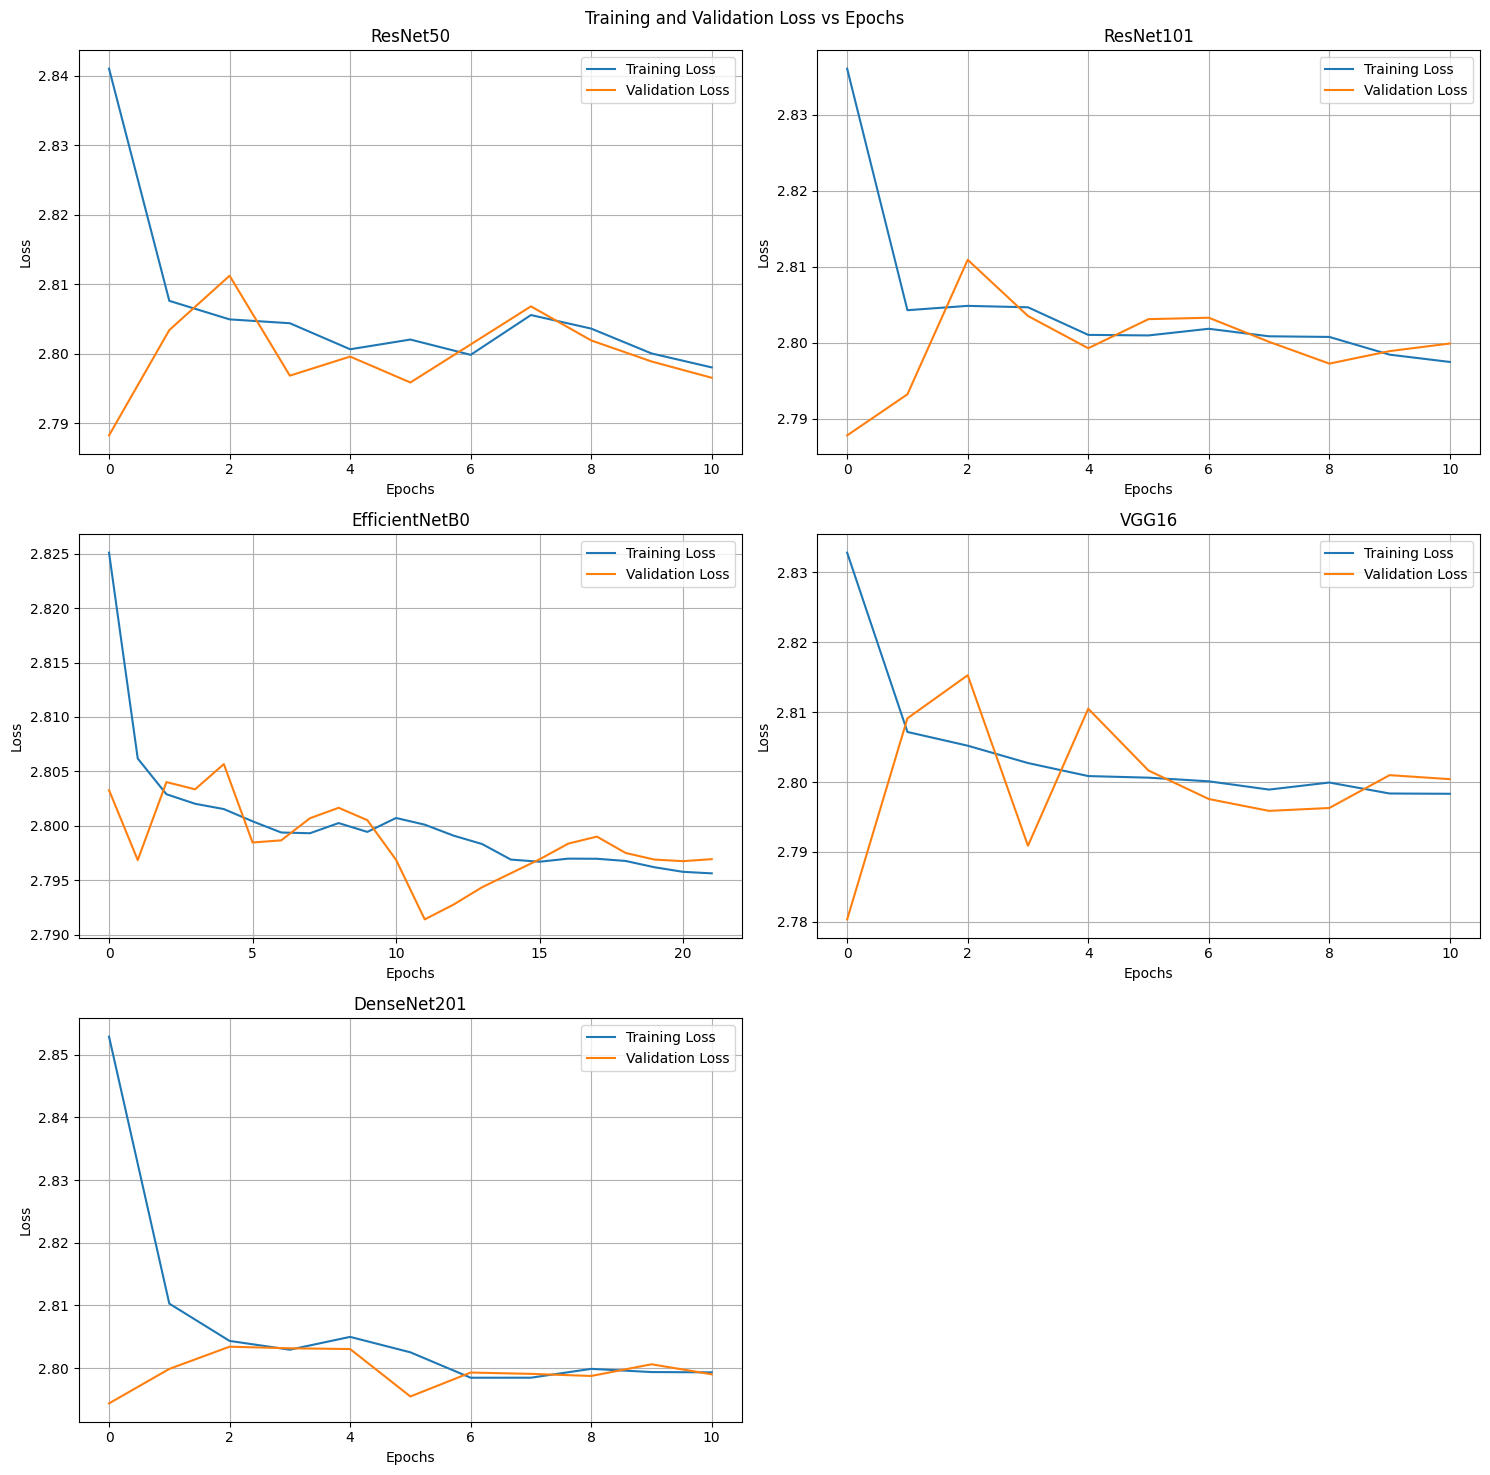

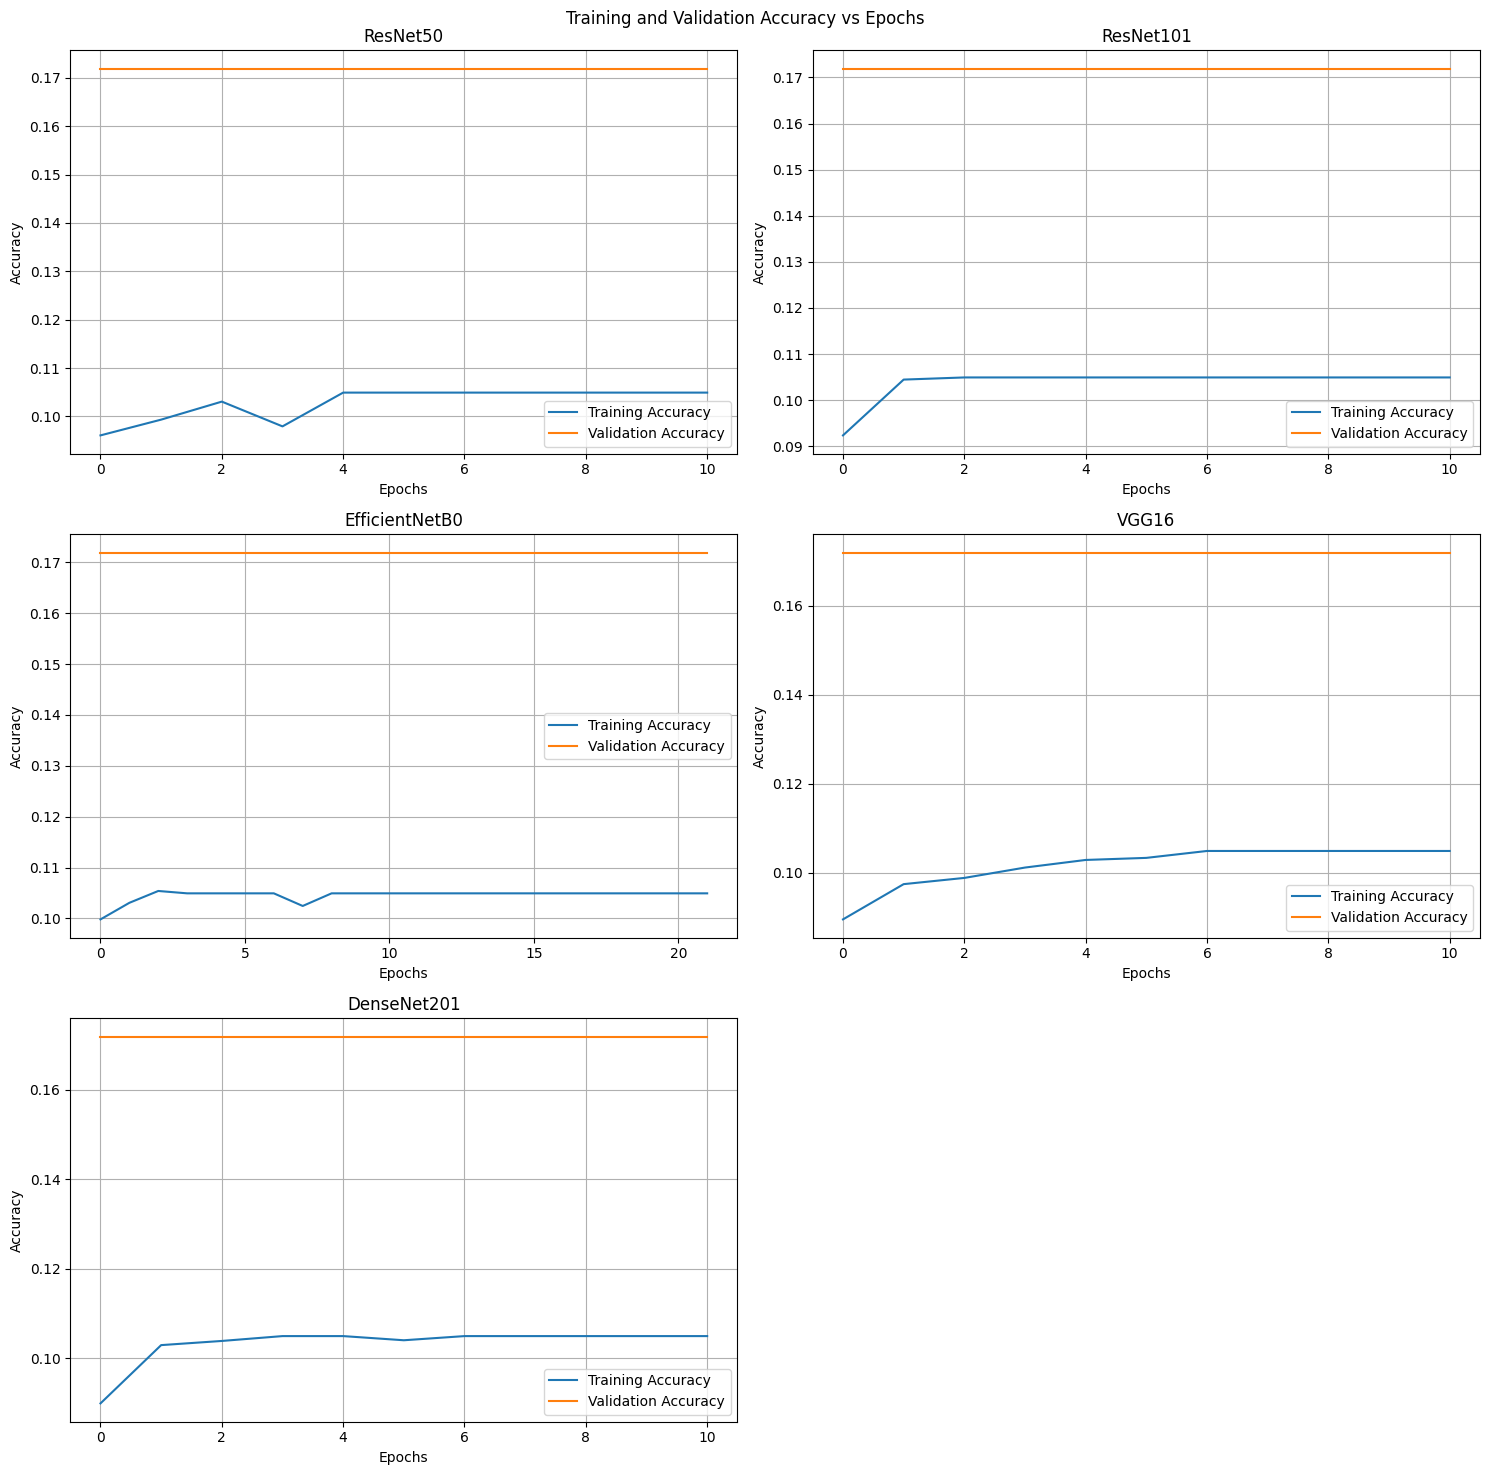

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, model_name in enumerate(model_names):
    history = hist[model_name]

    axes[idx].plot(history.history['loss'], label='Training Loss')
    axes[idx].plot(history.history['val_loss'], label='Validation Loss')
    axes[idx].set_title(f'{model_name}')
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid()

if len(model_names) < 6:
    fig.delaxes(axes[5])

plt.suptitle('Training and Validation Loss vs Epochs')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, model_name in enumerate(model_names):
    history = hist[model_name]

    axes[idx].plot(history.history['accuracy'], label='Training Accuracy')
    axes[idx].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[idx].set_title(f'{model_name}')
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].legend()
    axes[idx].grid()

if len(model_names) < 6:
    fig.delaxes(axes[5])

plt.suptitle('Training and Validation Accuracy vs Epochs')
plt.tight_layout()
plt.show()


#### (v)

In [13]:
res_summary = []

for model_name in model_names:
    print(f"{model_name}")
    model = models[model_name]

    train_loss, train_acc = model.evaluate(train_generator, verbose=0)

    train_generator.reset()
    y_train_pred = model.predict(train_generator, verbose=0)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true = train_generator.classes

    train_report = classification_report(y_train_true, y_train_pred_classes, output_dict=True, zero_division=0)
    y_train_binarized = label_binarize(y_train_true, classes=range(NUM_CLASSES))
    train_roc_auc = roc_auc_score(y_train_binarized, y_train_pred, average='macro', multi_class='ovr')

    print(f"Accuracy: {train_acc:.4f}")
    print(f"Precision: {train_report['macro avg']['precision']:.4f}")
    print(f"Recall: {train_report['macro avg']['recall']:.4f}")
    print(f"F1-Score: {train_report['macro avg']['f1-score']:.4f}")
    print(f"ROC-AUC: {train_roc_auc:.4f}")

    val_loss, val_acc = model.evaluate(val_generator, verbose=0)

    val_generator.reset()
    y_val_pred = model.predict(val_generator, verbose=0)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true = val_generator.classes

    val_report = classification_report(y_val_true, y_val_pred_classes, output_dict=True, zero_division=0)
    y_val_binarized = label_binarize(y_val_true, classes=range(NUM_CLASSES))
    val_roc_auc = roc_auc_score(y_val_binarized, y_val_pred, average='macro', multi_class='ovr')

    print(f"Accuracy: {val_acc:.4f}")
    print(f"Precision: {val_report['macro avg']['precision']:.4f}")
    print(f"Recall: {val_report['macro avg']['recall']:.4f}")
    print(f"F1-Score: {val_report['macro avg']['f1-score']:.4f}")
    print(f"ROC-AUC: {val_roc_auc:.4f}")

    test_loss, test_acc = model.evaluate(test_generator, verbose=0)

    test_generator.reset()
    y_test_pred = model.predict(test_generator, verbose=0)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true = test_generator.classes

    test_report = classification_report(y_test_true, y_test_pred_classes, output_dict=True, zero_division=0)
    y_test_binarized = label_binarize(y_test_true, classes=range(NUM_CLASSES))
    test_roc_auc = roc_auc_score(y_test_binarized, y_test_pred, average='macro', multi_class='ovr')

    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_report['macro avg']['precision']:.4f}")
    print(f"Recall: {test_report['macro avg']['recall']:.4f}")
    print(f"F1-Score: {test_report['macro avg']['f1-score']:.4f}")
    print(f"ROC-AUC: {test_roc_auc:.4f}")



ResNet50
Accuracy: 0.1049
Precision: 0.0062
Recall: 0.0588
F1-Score: 0.0112
ROC-AUC: 0.5024
Accuracy: 0.1719
Precision: 0.0101
Recall: 0.0588
F1-Score: 0.0173
ROC-AUC: 0.5000
Accuracy: 0.0633
Precision: 0.0037
Recall: 0.0588
F1-Score: 0.0070
ROC-AUC: 0.5000
ResNet101
Accuracy: 0.1049
Precision: 0.0062
Recall: 0.0588
F1-Score: 0.0112
ROC-AUC: 0.4989
Accuracy: 0.1719
Precision: 0.0101
Recall: 0.0588
F1-Score: 0.0173
ROC-AUC: 0.5000
Accuracy: 0.0633
Precision: 0.0037
Recall: 0.0588
F1-Score: 0.0070
ROC-AUC: 0.5000
EfficientNetB0
Accuracy: 0.1049
Precision: 0.0062
Recall: 0.0588
F1-Score: 0.0112
ROC-AUC: 0.5065
Accuracy: 0.1719
Precision: 0.0101
Recall: 0.0588
F1-Score: 0.0173
ROC-AUC: 0.5000
Accuracy: 0.0633
Precision: 0.0037
Recall: 0.0588
F1-Score: 0.0070
ROC-AUC: 0.5000
VGG16
Accuracy: 0.1049
Precision: 0.0062
Recall: 0.0588
F1-Score: 0.0112
ROC-AUC: 0.4992
Accuracy: 0.1719
Precision: 0.0101
Recall: 0.0588
F1-Score: 0.0173
ROC-AUC: 0.5000
Accuracy: 0.0633
Precision: 0.0037
Recall: 0.05